# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
from os import listdir
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import to_categorical

# Load Dataset

In [ ]:
directory_root = '/content/drive/MyDrive/Crop Disease/Image Data base'
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((150, 150))
image_size = 0
width=150
height=150
depth=1

In [ ]:
main_data_set = []
all_labels = []
root_dir = listdir(directory_root)

for plant_folder in root_dir :

  if plant_folder != 'Healthy':

    plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

    for img in plant_disease_folder_list:

      img_path = f'{directory_root}/{plant_folder}/{img}'
      main_data_set.append(img_path)
      all_labels.append(plant_folder)

In [ ]:
helthy_dirs = listdir(f"{directory_root}/Healthy")
for plant_folder in helthy_dirs :

  plant_disease_folder_list = listdir(f"{directory_root}/Healthy/{plant_folder}")

  for img in plant_disease_folder_list:

    img_path = f'{directory_root}/Healthy/{plant_folder}/{img}'
    main_data_set.append(img_path)
    all_labels.append('Healthy')

In [ ]:
print(f'Total Images {len(main_data_set)}')

Total Images 84206


In [ ]:
img_frame = dict(sorted(img_frame.items(), key=lambda item: item[1],reverse=True))

In [ ]:
df = pd.DataFrame({'Images':main_data_set,'Labels':all_labels})

In [ ]:
groups = df.groupby('Labels')

In [ ]:
img_frame = {}
for label in list(df['Labels'].unique()):
    group=groups.get_group(label)
    img_frame[label] = len(group)

In [ ]:
img_frame

{'Healthy': 15554,
 'Grape Black rot': 11372,
 'Apple Apple scab': 6117,
 'Apple Black rot': 6004,
 'Tomato Septoria leaf spot': 5313,
 'Tomato Spider mites Two spotted spider mite': 5038,
 'Tomato Bacterial spot': 4992,
 'Tomato Target Spot': 4224,
 'Common Rust in corn Leaf': 3918,
 'Blight in corn Leaf': 3438,
 'Potato Early blight': 3000,
 'Potato Late blight': 3000,
 'Tomato Early blight': 3000,
 'Apple Cedar apple rust': 2640,
 'Cherry (including sour) Powdery mildew': 2526,
 'Gray Leaf Spot in corn Leaf': 1760,
 'algal leaf in tea': 339,
 'brown blight in tea': 339,
 'anthracnose in tea': 300,
 'bird eye spot in tea': 300,
 'cabbage looper': 234,
 'Cercospora leaf spot': 189,
 'lemon canker': 183,
 'Bacterial leaf blight in rice leaf': 120,
 'Brown spot in rice leaf': 120,
 'Sogatella rice': 78,
 'potassium deficiency in plant': 54,
 'Nitrogen deficiency in plant': 33,
 'Waterlogging in plant': 21}

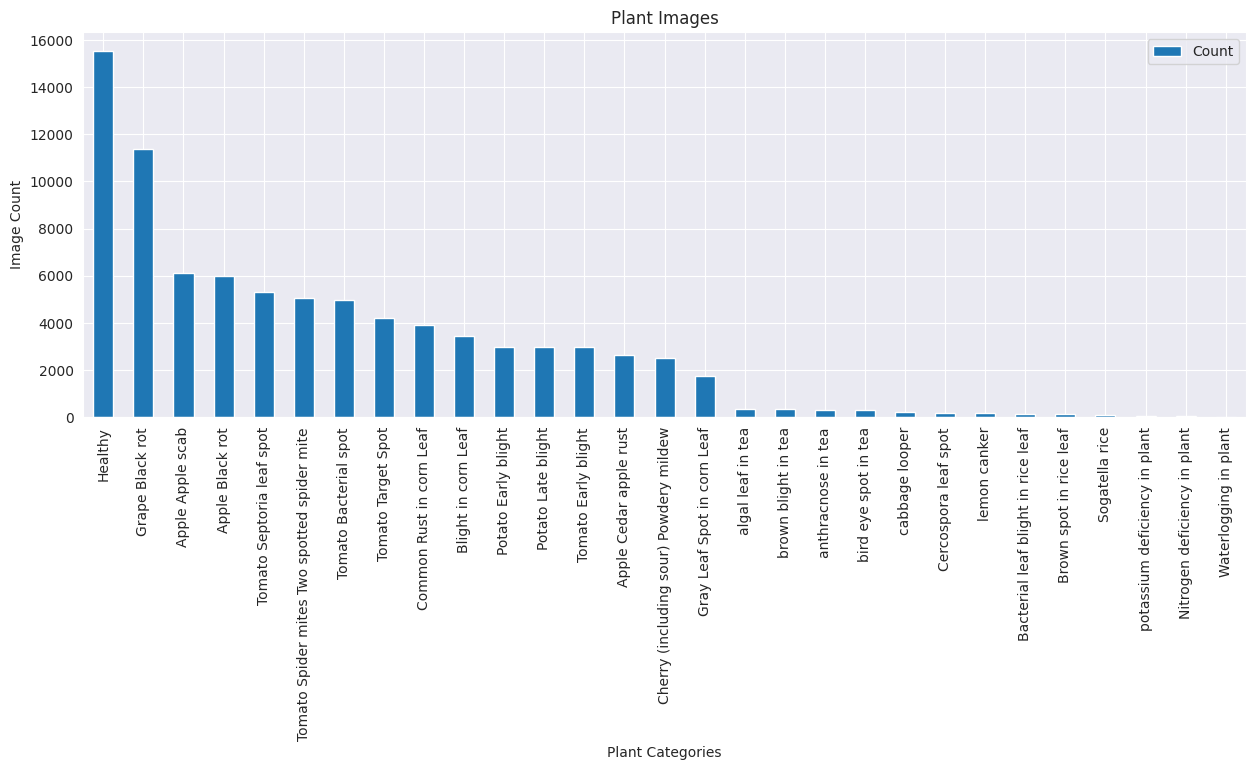

In [ ]:
pd_df = pd.DataFrame.from_dict({'Images':img_frame.keys(),'Count':img_frame.values()})
pd_df.plot(x='Images',y='Count',kind='bar',figsize=(15,5),title='Plant Images',xlabel='Plant Categories',ylabel='Image Count');

# Balance Dataset

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list,training_data,image_path = [], [],[],[]
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    dir = ''
    for plant_folder in root_dir :

        if plant_folder != 'Healthy':
          plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
          print(f"[INFO] Processing {plant_folder} ...")

          if len(plant_disease_folder_list) >= 200:
            for image in plant_disease_folder_list[:200]:

                image_directory = f'{directory_root}/{plant_folder}/{image}'
              
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                          image_list.append(convert_image_to_array(image_directory))
                          label_list.append(plant_folder)
                          image_path.append(image_directory)
        

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing algal leaf in tea ...
[INFO] Processing anthracnose in tea ...
[INFO] Processing Apple Apple scab ...
[INFO] Processing Apple Black rot ...
[INFO] Processing Apple Cedar apple rust ...
[INFO] Processing Bacterial leaf blight in rice leaf ...
[INFO] Processing bird eye spot in tea ...
[INFO] Processing Blight in corn Leaf ...
[INFO] Processing brown blight in tea ...
[INFO] Processing Brown spot in rice leaf ...
[INFO] Processing cabbage looper ...
[INFO] Processing Cercospora leaf spot ...
[INFO] Processing Cherry (including sour) Powdery mildew ...
[INFO] Processing Common Rust in corn Leaf ...
[INFO] Processing Grape Black rot ...
[INFO] Processing Gray Leaf Spot in corn Leaf ...
[INFO] Processing lemon canker ...
[INFO] Processing Nitrogen deficiency in plant ...
[INFO] Processing potassium deficiency in plant ...
[INFO] Processing Potato Early blight ...
[INFO] Processing Potato Late blight ...
[INFO] Processing Sogatella rice ...
[INFO] 

In [ ]:
plant_folder = 'Healthy'
plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

  
for h_folder in plant_disease_folder_list:

  h_dir = listdir(f'{directory_root}/{plant_folder}/{h_folder}')

  for image in h_dir[:25]:

    image_directory = f'{directory_root}/{plant_folder}/{h_folder}/{image}'
  
    if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
              image_list.append(convert_image_to_array(image_directory))
              label_list.append(plant_folder)
              image_path.append(image_directory)

In [ ]:
df_balance = pd.DataFrame({'Images':image_path,'Features':image_list,'Labels':label_list})

In [ ]:
df_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Images    4200 non-null   object
 1   Features  4200 non-null   object
 2   Labels    4200 non-null   object
dtypes: object(3)
memory usage: 98.6+ KB


In [ ]:
df_balance.isna().sum()

Images      0
Features    0
Labels      0
Category    0
dtype: int64

In [ ]:
groups_b = df_balance.groupby('Labels')

In [ ]:
img_frame_b = {}
for label in list(df_balance['Labels'].unique()):
    group=groups_b.get_group(label)
    img_frame_b[label] = len(group)

In [ ]:
Unique_Img = df_balance['Images'].unique()
Original_Img = df_balance['Images']

In [ ]:
print('The total number of original images',len(Original_Img))
print('The total number of unique images',len(Unique_Img))

The total number of original images 4200
The total number of unique images 4200


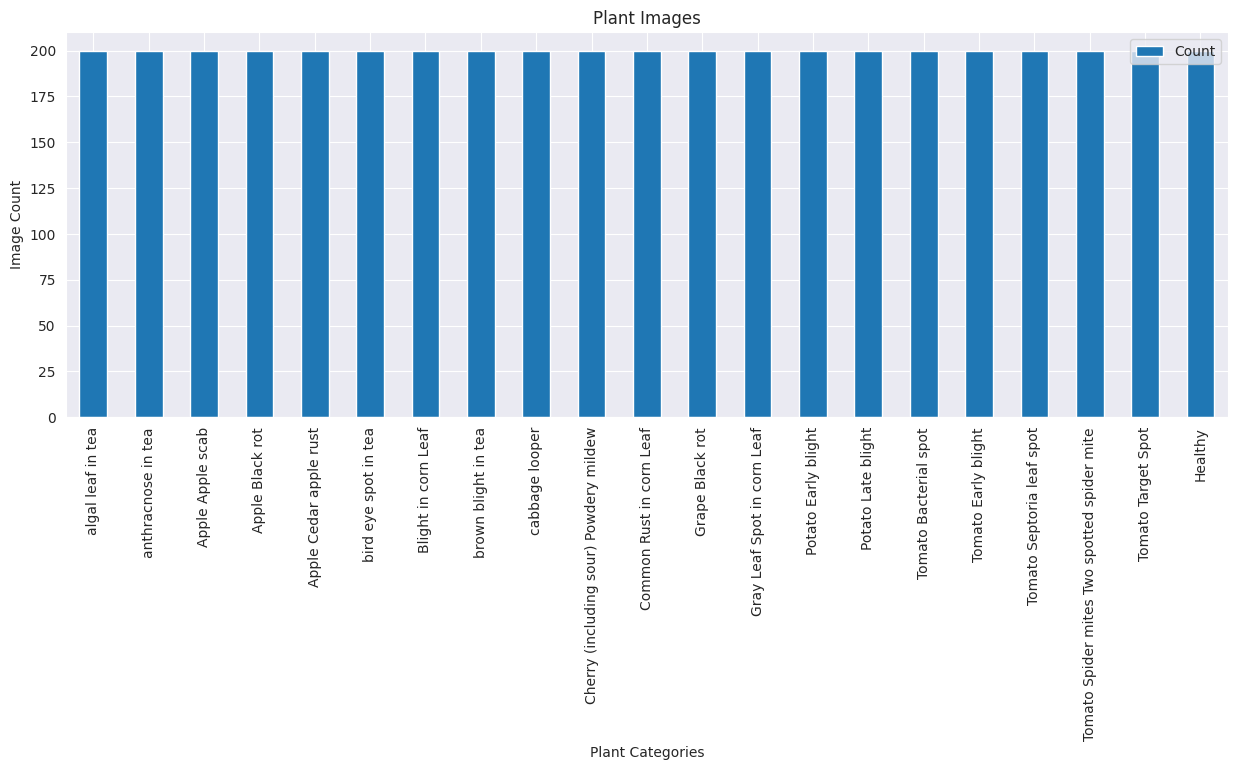

In [ ]:
pd_df = pd.DataFrame.from_dict({'Images':img_frame_b.keys(),'Count':img_frame_b.values()})
pd_df.plot(x='Images',y='Count',kind='bar',figsize=(15,5),title='Plant Images',xlabel='Plant Categories',ylabel='Image Count');

In [ ]:
df_balance['Category'] = pd.factorize(df_balance['Labels'], sort=False)[0]

In [ ]:
df_balance

Images  \
0     /content/drive/MyDrive/Crop Disease/Image Data...   
1     /content/drive/MyDrive/Crop Disease/Image Data...   
2     /content/drive/MyDrive/Crop Disease/Image Data...   
3     /content/drive/MyDrive/Crop Disease/Image Data...   
4     /content/drive/MyDrive/Crop Disease/Image Data...   
...                                                 ...   
4195  /content/drive/MyDrive/Crop Disease/Image Data...   
4196  /content/drive/MyDrive/Crop Disease/Image Data...   
4197  /content/drive/MyDrive/Crop Disease/Image Data...   
4198  /content/drive/MyDrive/Crop Disease/Image Data...   
4199  /content/drive/MyDrive/Crop Disease/Image Data...   

                                               Features             Labels  \
0     [[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...  algal leaf in tea   
1     [[[247.0, 243.0, 248.0], [248.0, 244.0, 249.0]...  algal leaf in tea   
2     [[[212.0, 209.0, 224.0], [217.0, 215.0, 227.0]...  algal leaf in tea   
3     [[[217.0, 218.0, 238.0], [216.0, 220.0, 238.0]...  algal leaf in tea   
4     [[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...  algal leaf in tea   
...                                                 ...                ...   
4195  [[[179.0, 181.0, 192.0], [182.0, 184.0, 195.0]...            Healthy   
4196  [[[152.0, 148.0, 154.0], [147.0, 143.0, 149.0]...            Healthy   
4197  [[[177.0, 178.0, 192.0], [171.0, 172.0, 186.0]...            Healthy   
4198  [[[149.0, 145.0, 156.0], [177.0, 173.0, 184.0]...            Healthy   
4199  [[[169.0, 171.0, 182.0], [169.0, 171.0, 182.0]...            Healthy   

      Category  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
4195        20  
4196        20  
4197        20  
4198        20  
4199        20  

[4200 rows x 4 columns]

In [ ]:
df_balance.groupby('Category').nth(0)

Images  \
Category                                                      
0         /content/drive/MyDrive/Crop Disease/Image Data...   
1         /content/drive/MyDrive/Crop Disease/Image Data...   
2         /content/drive/MyDrive/Crop Disease/Image Data...   
3         /content/drive/MyDrive/Crop Disease/Image Data...   
4         /content/drive/MyDrive/Crop Disease/Image Data...   
5         /content/drive/MyDrive/Crop Disease/Image Data...   
6         /content/drive/MyDrive/Crop Disease/Image Data...   
7         /content/drive/MyDrive/Crop Disease/Image Data...   
8         /content/drive/MyDrive/Crop Disease/Image Data...   
9         /content/drive/MyDrive/Crop Disease/Image Data...   
10        /content/drive/MyDrive/Crop Disease/Image Data...   
11        /content/drive/MyDrive/Crop Disease/Image Data...   
12        /content/drive/MyDrive/Crop Disease/Image Data...   
13        /content/drive/MyDrive/Crop Disease/Image Data...   
14        /content/drive/MyDrive/Crop Disease/Image Data...   
15        /content/drive/MyDrive/Crop Disease/Image Data...   
16        /content/drive/MyDrive/Crop Disease/Image Data...   
17        /content/drive/MyDrive/Crop Disease/Image Data...   
18        /content/drive/MyDrive/Crop Disease/Image Data...   
19        /content/drive/MyDrive/Crop Disease/Image Data...   
20        /content/drive/MyDrive/Crop Disease/Image Data...   

                                                   Features  \
Category                                                      
0         [[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...   
1         [[[117.0, 99.0, 124.0], [113.0, 100.0, 125.0],...   
2         [[[164.0, 135.0, 151.0], [167.0, 138.0, 153.0]...   
3         [[[157.0, 134.0, 148.0], [164.0, 141.0, 155.0]...   
4         [[[117.0, 120.0, 125.0], [135.0, 138.0, 143.0]...   
5         [[[17.0, 23.0, 60.0], [17.0, 25.0, 62.0], [10....   
6         [[[151.0, 246.0, 246.0], [114.0, 227.0, 227.0]...   
7         [[[243.0, 239.0, 251.0], [241.0, 238.0, 250.0]...   
8         [[[47.0, 27.0, 25.0], [94.0, 69.0, 65.0], [97....   
9         [[[77.0, 81.0, 86.0], [71.0, 75.0, 80.0], [69....   
10        [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
11        [[[119.0, 120.0, 130.0], [108.0, 109.0, 119.0]...   
12        [[[157.0, 144.0, 152.0], [157.0, 144.0, 152.0]...   
13        [[[169.0, 150.0, 147.0], [166.0, 147.0, 144.0]...   
14        [[[109.0, 88.0, 96.0], [109.0, 88.0, 96.0], [1...   
15        [[[136.0, 136.0, 142.0], [153.0, 153.0, 159.0]...   
16        [[[182.0, 177.0, 176.0], [179.0, 174.0, 174.0]...   
17        [[[195.0, 161.0, 161.0], [197.0, 163.0, 163.0]...   
18        [[[143.0, 157.0, 176.0], [132.0, 146.0, 165.0]...   
19        [[[140.0, 133.0, 146.0], [147.0, 140.0, 153.0]...   
20        [[[172.0, 146.0, 134.0], [170.0, 144.0, 132.0]...   

                                               Labels  
Category                                               
0                                   algal leaf in tea  
1                                  anthracnose in tea  
2                                    Apple Apple scab  
3                                     Apple Black rot  
4                              Apple Cedar apple rust  
5                                bird eye spot in tea  
6                                 Blight in corn Leaf  
7                                 brown blight in tea  
8                                      cabbage looper  
9              Cherry (including sour) Powdery mildew  
10                           Common Rust in corn Leaf  
11                                    Grape Black rot  
12                        Gray Leaf Spot in corn Leaf  
13                                Potato Early blight  
14                                 Potato Late blight  
15                              Tomato Bacterial spot  
16                                Tomato Early blight  
17                          Tomato Septoria leaf spot  
18        Tomato Spider mites Two

# Show Healthy and Unhealthy Images

In [ ]:
Unhealthy_Images = []
Unhealthy_labels = []

root_dir = listdir(directory_root)

for plant_folder in root_dir :

  if plant_folder != 'Healthy':

    plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

    for image in plant_disease_folder_list[:1]:

      image_directory = f'{directory_root}/{plant_folder}/{image}'

      Unhealthy_Images.append(convert_image_to_array(image_directory))
      Unhealthy_labels.append(plant_folder)

In [ ]:
plant_folder = 'Healthy'
plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

Healthy_images = []
Healthy_labels = []
  
for h_folder in plant_disease_folder_list:

  h_dir = listdir(f'{directory_root}/{plant_folder}/{h_folder}')

  for image in h_dir[:1]:
    image_directory = f'{directory_root}/{plant_folder}/{h_folder}/{image}'
  
    if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
              Healthy_images.append(convert_image_to_array(image_directory))
              Healthy_labels.append(h_folder)

In [ ]:
def show_image_samples(images,labels ):
    classes=labels    
    plt.figure(figsize=(20, 20))
    length=len(labels)

    for i in range(length):        
        plt.subplot(5, 6, i+1)
        image=images[i]/255      
        plt.imshow(image)
        class_name=labels[i]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()



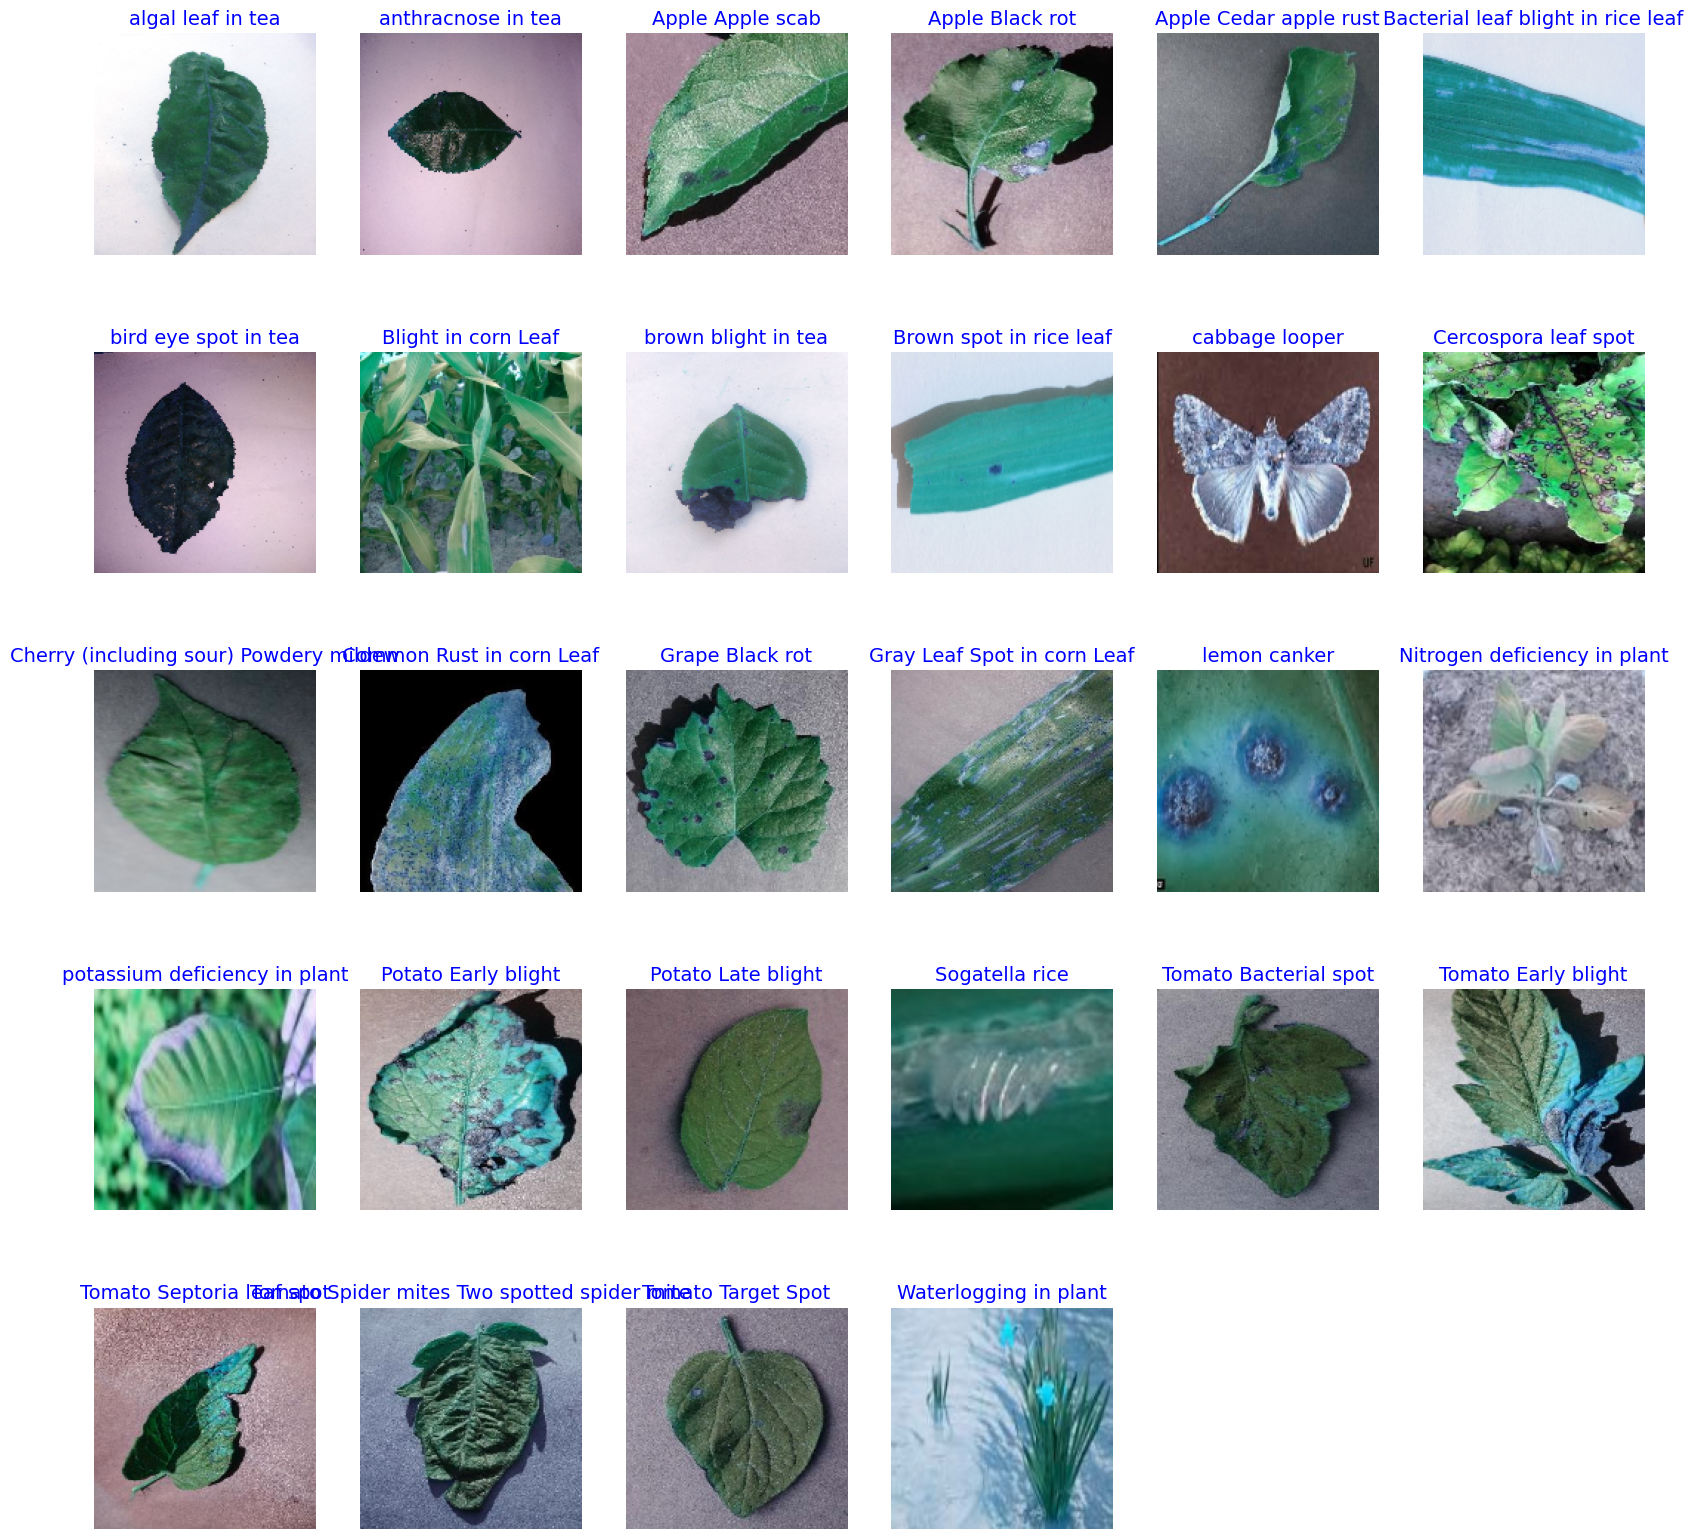

In [ ]:
show_image_samples(Unhealthy_Images,Unhealthy_labels)

In [ ]:
def show_image_Healthy(images,labels ):
    classes=labels    
    plt.figure(figsize=(20, 10))
    length=len(labels)

    for i in range(length):        
        plt.subplot(2, 4, i+1)
        image=images[i]/255      
        plt.imshow(image)
        class_name=labels[i]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()



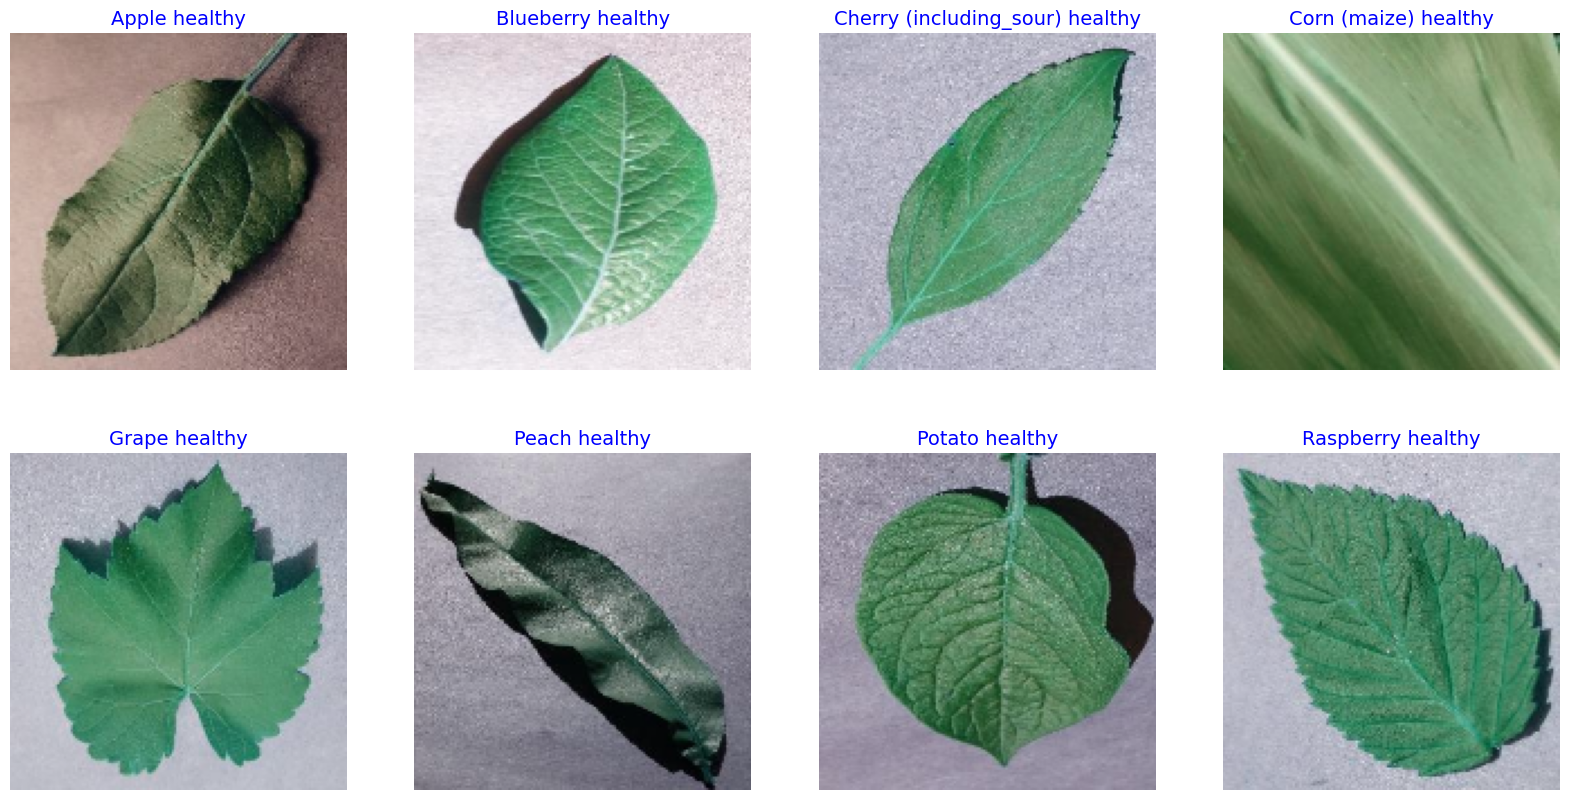

In [ ]:
show_image_Healthy(Healthy_images,Healthy_labels)

# Data Transformation

In [ ]:
height = []
width = []
for i in range (len(image_path)):
    fpath=image_path[i]
    img=plt.imread(fpath)
    shape=img.shape
    height.append(shape[0])
    width.append(shape[1])

In [ ]:
df_box = pd.DataFrame({"Height": height, "Width": width})

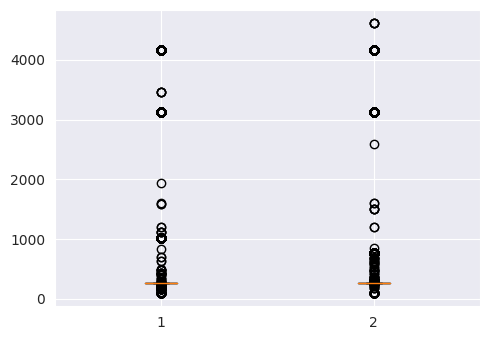

In [ ]:
plt.rcParams["figure.figsize"] = [5, 3.50]
plt.rcParams["figure.autolayout"] = True

ax = plt.boxplot(df_box)

# Display the plot
plt.show()

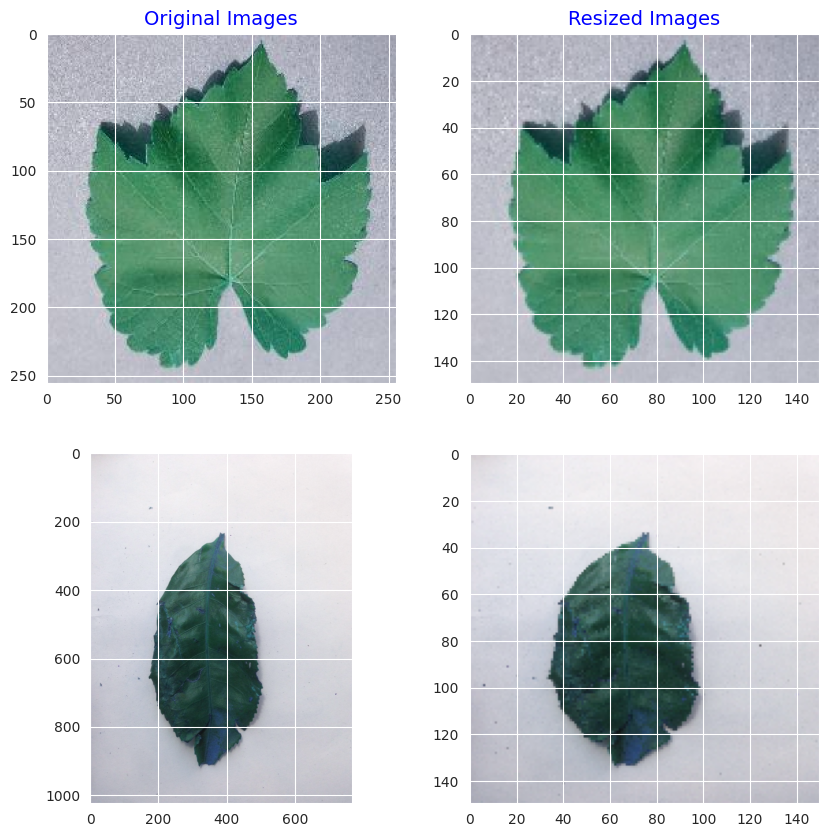

In [ ]:
img_arr = [image_path[4100],image_list[4100],image_path[11],image_list[11]]
label_arr = ['Original Images', 'Resized Images']

classes=label_arr    
plt.figure(figsize=(10, 10))
length=len(img_arr)

for i in range(length):        
    plt.subplot(2, 2, i+1)

    if i %2 != 0:

      image=img_arr[i]/255      
      plt.imshow(image)

    else:
      img = cv2.imread(img_arr[i])
      plt.imshow(img)
      
    if i == 0 or i == 1:
      class_name=label_arr[i]
      plt.title(class_name, color='blue', fontsize=14)
    # plt.axis('off')
plt.show()

# Data Augmentation

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
X_aug_train = np.array(image_list[1:2], dtype=np.float16) / 225.0
y_aug_train = df_balance.Category[1:2]

In [ ]:
augmented = aug.flow(X_aug_train, y_aug_train, batch_size=1)

In [ ]:
img_arr = []
b = (image_list[1])/255
img_arr.append(b)

In [ ]:
a = augmented[0][0][0]
img_arr.append(a)

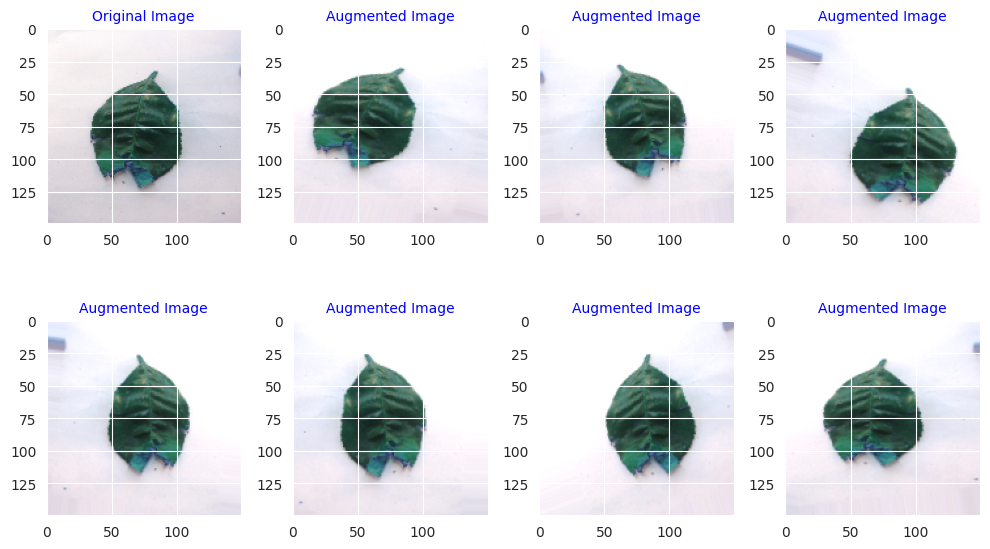

In [ ]:
label_arr = ['Original Image', 'Augmented Image']

classes=label_arr    
plt.figure(figsize=(10, 6))
length=len(img_arr)

for i in range(length):        
    plt.subplot(2, 4, i+1)

    plt.imshow(img_arr[i])
    class_name=''

    if i == 0:
      class_name = 'Original Image'

    else:
      class_name = 'Augmented Image'

    plt.title(class_name, color='blue', fontsize=10)
    # plt.axis('off')
plt.show()

# Train-Test-Validation Splits

In [ ]:
train_df, dummy_df=train_test_split(df_balance, train_size=.8, shuffle=True, random_state=123, stratify=df_balance['Labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['Labels'])

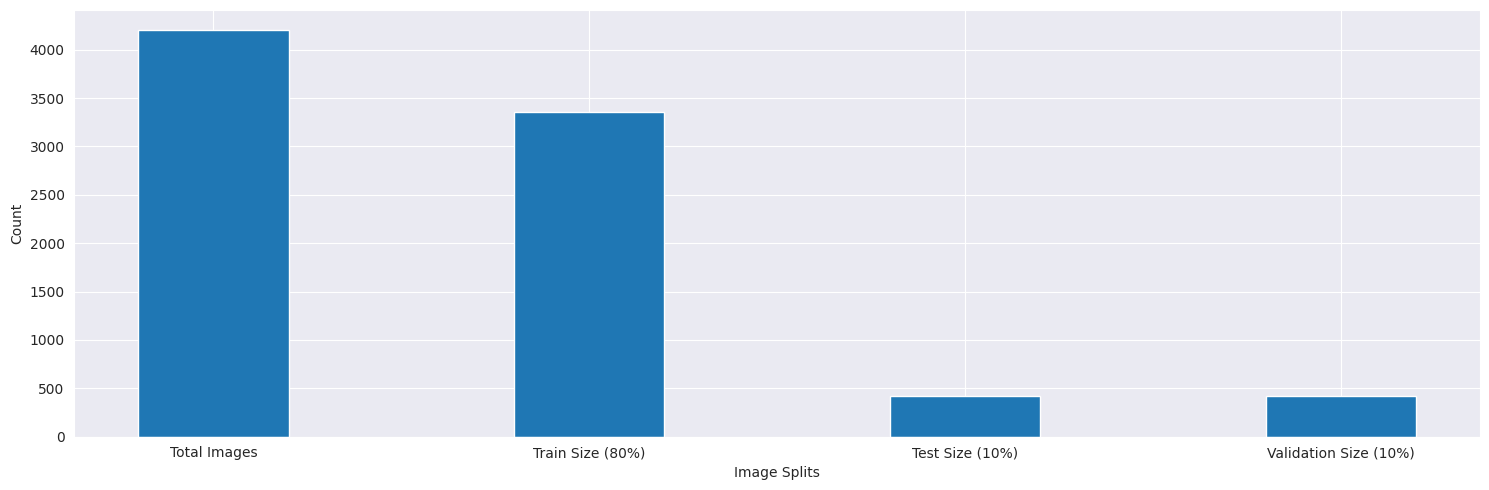

In [ ]:
img_splits = {'Total Images':len(df_balance),'Train Size (80%)':len(train_df),'Test Size (10%)':len(test_df),'Validation Size (10%)':len(valid_df)}

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(img_splits.keys(), img_splits.values(),width=0.4)
ax.set(xlabel='Image Splits',ylabel='Count');